# Literature

$[1]$ --- Implementable tensor methods in unconstrained convex optimization, https://alfresco.uclouvain.be/alfresco/service/guest/streamDownload/workspace/SpacesStore/aabc2323-0bc1-40d4-9653-1c29971e7bd8/coredp2018_05web.pdf?guest=true.

$[2]$ ---  Cubic regularization of Newton method and its global performance, http://lab7.ipu.ru/files/polyak/Nest_Pol-MathProg'06.pdf.

$[3]$ --- Acelerating the cubic regularization of Newton’s method on convex
problems, http://webdoc.sub.gwdg.de/ebook/serien/e/CORE/dp2005_68.pdf.

$[4]$ --- A.R. Conn, N.I. M. Gould, and Ph.L. Toint. Trust Region Methods. SIAM, Philadelphia, 2000.

$[5]$ --- Анализ быстрого градиентного метода Нестерова для задач машинного обучения с $L_1$-регуляризацией, http://www.machinelearning.ru/wiki/images/0/03/Rodomanov_FGM.pdf.

# Purpose of code: plot graphs for methods $[1]$.$[2.16]$ and $[1]$.$[3.12]$ with $p = 2$ and $p = 3$ by testing on logistic regression problem

##### Import libraries

In [18]:
#import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import minimize_scalar, minimize
import autograd.numpy as np  # Thinly-wrapped numpy
from numpy import linalg, loadtxt
import math
import autograd.scipy as scipy
from scipy import optimize
import copy

##### Calculation parameters $c, A \succeq 0, \gamma > 0$ for auxiliary minimization problem $[1]$.$[5.8]$ in terms of problem 
$$
\langle c, h \rangle + \frac{1}{2}\langle Ah, h \rangle + \frac{\gamma}{4}||h||_2^4 \rightarrow \min\limits_{h \in \mathbb{R}^n}
$$ 

In [2]:
def calc_cur_params(grad_f_cur, hessian_f_cur, tensor3_f_cur_vect, hk, tau, L):
    grad_d = np.dot(hk, hk.T)*hk
    c = (grad_f_cur - 1/tau*np.dot(hessian_f_cur, hk.T) + 0.5*tensor3_f_cur_vect 
                                                                        - tau*(tau + 1)/2*L*grad_d) + tau*tau*L/2*grad_d
    
    A = (tau + 1) / tau * hessian_f_cur
    
    gamma = tau*(tau + 1)/2*L
    return c, A, gamma

##### Objective function $f_{c, A, \gamma}(h) = \langle c, h \rangle + \frac{1}{2}\langle Ah, h \rangle + \frac{\gamma}{4}||h||_2^4$ for auxiliary minimization problem $[1]$.$[5.8]$ and its univariate dual function $g_{c, A, \gamma}(\tau) = \frac{1}{2}\tau^2 + \frac{1}{2}\Bigl\langle \bigl(\sqrt{2\gamma}\tau B + A\bigr)^{-1}c, c \Bigr\rangle$ with $B = I_{n \times n}$ for Euclid 2-norm.

In [3]:
def aux_problem_func(h, *args):
    c, A, gamma = args
    d = linalg.norm(h)
    d4 = d*d*d*d
    return np.dot(c, h) + 0.5 * np.dot(np.dot(A, h), h) + 0.25*gamma*d4 

def aux_problem_onedim_func(tau, *args):
    c, A, B, gamma = args
    sgam = math.sqrt(2*gamma)
    S = sgam*tau*B + A
    invS = linalg.inv(S)
    f = 0.5*tau*tau + 0.5 * np.dot(np.dot(invS, c), c)
    
    return f

##### Calculation minimum of $f_{c, A, \gamma}(h)$ using minimum of dual function $g_{c, A, \gamma}(\tau)$.

In [4]:
def calc_hopt(t, *args):
    c, A, B, gamma = args
    S = math.sqrt(2*gamma)*t*B + A
    invS = linalg.inv(S)
    h_opt = -np.dot(invS, c)
    return h_opt

##### Newton's method for finding minimum $g_{c, A, \gamma}(\tau)$ based on $[4]$, Chapter $7$.

The main idea is to find root $\lambda > 0$ of first-order optimality condition: $\sqrt{\lambda} = ||s(\lambda)||_2, s(\lambda) = -(A + \lambda I)^{-1}c_{\text{new}}, \lambda = \sqrt{2\gamma}\tau, c_{\text{new}} = \sqrt{\gamma}c$.

It is better to solve the secular equation:
$$
\phi(\lambda) = \frac{1}{||s(\lambda)||_{2}} - \frac{1}{\sqrt{\lambda}}.
$$
So 
$$
\phi^{'}(\lambda) = \frac{\bigl \langle s(\lambda), A(\lambda)^{-1}s(\lambda) \bigr \rangle}{||s(\lambda)||_2^3} + \frac{1}{2\lambda^{\frac{3}{2}}} \geq 0, A(\lambda) = A + \lambda I;
$$
$$
\phi^{''}(\lambda) = \frac{3\Bigl(\bigl \langle s(\lambda), \nabla_{\lambda}s(\lambda) \bigr \rangle^2 - ||s(\lambda)||_2^2||\nabla_{\lambda}s(\lambda)||_2^2\Bigr)}{||s(\lambda)||_2^5} - \frac{3}{4\lambda^{\frac{5}{2}}} < 0
$$ by Cauchy-Schwartz inequality.

Newton's method for finding a root of the scalar equation $\phi(\lambda) = 0$ replaces  the estimate $\lambda_k > 0$ with the improved estimate $\lambda_{k + 1}$ for which
$$
\lambda_{k + 1} = \lambda_k - \frac{\phi(\lambda_k)}{\phi^{'}(\lambda_k)}.
$$
Using Cholesky factors $A(\lambda) = L(\lambda)L^T(\lambda)$ we can write:
$$
\bigl \langle s, A(\lambda)^{-1}s \bigr \rangle = \bigl \langle s, L^{-T}L^{-1}s \bigr \rangle = \bigl \langle L^{-1}s, L^{-1}s \bigr \rangle = ||w(\lambda)||_2^2
$$
with $w(\lambda) = L^{-1}(\lambda)s(\lambda)$.
The complete Newton algorithm is:
$$
\lambda_{k + 1} = \lambda_k \cdot \Bigl(1 - 2||s(\lambda_k)||_2^2\frac{\sqrt{\lambda_k} - ||s(\lambda_k)||_2}{||s(\lambda_k)||_2^3 + 2||w(\lambda_k)||_2^2\lambda_k^{\frac{3}{2}}}\Bigr) 
$$ while $\lambda_{k + 1} > 0$.

In [5]:
def Newton_step_tensor3(AuxMaxIter, *args):
    c, H, gamma, eps = args
    c_new = c*(gamma**0.5)
    lambda_ans = eps
    k = 0
    while (k < AuxMaxIter):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        try:
            L = linalg.cholesky(H_lambda)
        except np.linalg.LinAlgError:
            break
        s = linalg.solve(H_lambda, -c_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            2*(lambda_ans**0.5 - linalg.norm(s))*(linalg.norm(s)**2)/
                                  (linalg.norm(s)**3 + 2*(linalg.norm(w)**2)*(lambda_ans**(1.5))))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    #tau_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + lambda_ans*np.identity(H.shape[0])), c)
    #h_opt2 = -np.dot(linalg.pinv(H), c)
    #val_1 = np.dot(c, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + gamma/4*(linalg.norm(h_opt1)**4)
    #val_2 = np.dot(c, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + gamma/4*(linalg.norm(h_opt2)**4)
    #if (val_1 < val_2):
     #   h_opt = h_opt1
    #else:
      #  h_opt = h_opt2
    #return h_opt
    return h_opt1

##### Iteration of process $[1].[5.8]$ to solve auxiliary minimization problem $[1]$.$[5.4]$.

In [6]:
def T3M(x, aux_prob_method, grad_f_cur, hess_f_cur, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, eps, *args):
    
    size = x.shape[0]
    hk = np.zeros(size)
    B = np.eye(size)
 
    if aux_prob_method == 1:
        xb = L*1e10
        t0 = 0+eps
    
    for aux_k in range(1, TensorMaxIter + 1):
        tensor3_f_cur_vect = tensor3_f_direct(x, hk, *args)
        c, A, gamma = calc_cur_params(grad_f_cur, hess_f_cur, tensor3_f_cur_vect, hk, tau, L)
            
        if aux_prob_method == 1:
            allargs = (c, A, B, gamma)

            res = optimize.minimize_scalar(aux_problem_onedim_func, args = allargs, method = 'bounded', bounds=(t0, xb), 
                                                            options={'maxiter': AuxMaxIter, 'disp': False})
            
            tau_opt = res.x
            
            h_opt = calc_hopt(tau_opt, *(c, A, B, gamma))
                
        elif aux_prob_method == 2:
            allargs = (c, A, gamma)
        
            res = optimize.minimize(aux_problem_func, args = allargs, tol = eps, x0 = hk, method = 'Powell', 
                                                                        options={'maxiter': AuxMaxIter, 'disp': False})                
            h_opt = res.x
                
        elif aux_prob_method == 3:
            h_opt = Newton_step_tensor3(AuxMaxIter, *(c, A, gamma, eps))
        hk = h_opt
    return (hk + x)   

##### Tensor method $[1]$.$[2.16]$ by Yu. Nesterov (2018), $p = 3$
Parameters:  
$NumIter$ --- max number of steps in tensor method.

$TensorMaxIter$ --- max number of iterations in auxiliary problem solution method $[1]$.$[5.8]$.

$AuxMaxIter$ --- max number of iterations to perform step $[1]$.$[5.8]$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle.

$\langle \nabla^3 f(x) h, h \rangle$ --- objective third directional derivative of $f$ at $x$ along direction $h$ oracle .

$\tau > 1$ - parameter in $[1]$.$[5.5]$.

$L_3(f)$ - uniform bound for the Lipschitz constant of third derivative.

$\varepsilon$ - parameter to perform step $[1]$.$[5.8]$, meaning depends of $aux\_prob\_method$.

$aux\_prob\_method$ --- how to solve auxiliary problem (5.4): $1$ --- by means of minimization $g_{c, A, \gamma}(\tau)$ using $scipy.optimize$, $2$ --- by means of minimization $f_{c, A, \gamma}(h)$ using $scipy.optimize$, $3$ --- by means of minimization $g_{c, A, \gamma}(\tau)$ using Newton's method.

$args$ - arguments for parametrization of $f$.

In [7]:
def Tensor3_iter(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                                             aux_prob_method, *args):
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)

    for k in range(NumIter):
        f_xk = f(xk, *args)
        grad_f_xk = grad_f(xk, *args)
        hessian_f_xk = hess_f(xk, *args)
        farr[k] = f_xk
        #fgradarr[k] = linalg.norm(grad_f_xk)
        xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter,
                                                             tau, L, eps, *args) 
    
    f_xk = f(xk, *args)
    #grad_f_xk = grad_f(xk, *args)
    farr[NumIter] = f_xk
    #fgradarr[NumIter] = linalg.norm(grad_f_xk)
    
    return xk, f_xk, farr#, fgradarr

##### Prox function

In [8]:
def proxd(x, p):
    return 1. / p * (linalg.norm(x)**p) 

##### Accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018), $p = 3$

This method has additional parameter $version$ = 1 if we use formula for $A_k$ (as is $[1]$.$[3.11]$):
$$
A_k = \Bigl[\frac{(p - 1)(M^2 - L_p^2)}{4(p + 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}
$$
and $version$ = 2 if we use formula for $A_k$:
$$
A_k = \Bigl[\frac{(p + 1)(M^2 - L_p^2)}{4(p - 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}.
$$
Both versions use formula $[1]$.$[5.5]$:
$$
M = \tau^2 L_3.
$$

In [9]:
def TensorAcc3_iter(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                               aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    farr[0] = f_xk
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, 
                                                                                                         eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 3
    C = p / 2 * math.sqrt((p+1)/(p-1)*(M*M - L*L))
    
    min_psik = copy.deepcopy(x0)
    size = x0.shape[0]
    sk = np.zeros(size)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L*L) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L*L) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T3M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, 
                                                                                     tau, L, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, f_xk, farr#, fgradarr, k

##### Accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018) with printing history, $p = 3$

In [53]:
def TensorAcc3_iter_hist(NumIter, TensorMaxIter, AuxMaxIter, x0, f, grad_f, hess_f, tensor3_f_direct, tau, L, eps, 
                                               aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    print("iter = {0}, f_k = {1}".format(0, f_xk))
    farr[0] = f_xk
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T3M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, tau, L, 
                                                                                                         eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    print("iter = {0}, f_k = {1}".format(1, f_xk))
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    
    p = 3
    C = p / 2 * math.sqrt((p+1)/(p-1)*(M*M - L*L))
    
    min_psik = copy.deepcopy(x0)
    size = x0.shape[0]
    sk = np.zeros(size)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L*L) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L*L) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T3M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, tensor3_f_direct, TensorMaxIter, AuxMaxIter, 
                                                                                     tau, L, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        print("iter = {0}, f_k = {1}".format(k + 1, f_xk))
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, farr#, fgradarr, k


##### Newton's method for finding minimum $\Omega_{g, H, M}(h) = \langle g, h \rangle + \frac{1}{2}\langle Hh, h \rangle + \frac{M}{6}||h||_2^3$ in $[3]$.$[5.1]$ based on one-dimensional equation $[3]$.$[5.4]$ and methods in $[4]$, Chapter $7$. Note that we assume $M > 0, H \succeq 0$.

The main idea is to find root $ \lambda_{\text{root}} > 0$ of first-order optimality condition: $\lambda = ||s(\lambda)||_2, s(\lambda) = -(H + \lambda I)^{-1}g_{\text{new}}, \lambda = \frac{M}{2}||h_{\text{opt}}||_2, g_{\text{new}} = \frac{M}{2}g, h = -(H + \lambda_{\text{root}} I)^{-1}g$.

It is better to solve the secular equation:
$$
\phi(\lambda) = \frac{1}{||s(\lambda)||_{2}} - \frac{1}{\lambda}.
$$
So 
$$
\phi^{'}(\lambda) = \frac{\bigl \langle s(\lambda), A(\lambda)^{-1}s(\lambda) \bigr \rangle}{||s(\lambda)||_2^3} + \frac{1}{\lambda^2} \geq 0, A(\lambda) = A + \lambda I;
$$
$$
\phi^{''}(\lambda) = \frac{3\Bigl(\bigl \langle s(\lambda), \nabla_{\lambda}s(\lambda) \bigr \rangle^2 - ||s(\lambda)||_2^2||\nabla_{\lambda}s(\lambda)||_2^2\Bigr)}{||s(\lambda)||_2^5} - \frac{2}{\lambda^3} < 0
$$ by Cauchy-Schwartz inequality.

Newton's method for finding a root of the scalar equation $\phi(\lambda) = 0$ replaces  the estimate $\lambda_k > 0$ with the improved estimate $\lambda_{k + 1}$ for which
$$
\lambda_{k + 1} = \lambda_k - \frac{\phi(\lambda_k)}{\phi^{'}(\lambda_k)}.
$$
Using Cholesky factors $A(\lambda) = L(\lambda)L^T(\lambda)$ we can write:
$$
\bigl \langle s, A(\lambda)^{-1}s \bigr \rangle = \bigl \langle s, L^{-T}L^{-1}s \bigr \rangle = \bigl \langle L^{-1}s, L^{-1}s \bigr \rangle = ||w(\lambda)||_2^2
$$
with $w(\lambda) = L^{-1}(\lambda)s(\lambda)$.
The complete Newton algorithm is:
$$
\lambda_{k + 1} = \lambda_k \cdot \Bigl(1 - ||s(\lambda_k)||_2^2\frac{\lambda_k - ||s(\lambda_k)||_2}{||s(\lambda_k)||_2^3 + ||w(\lambda_k)||_2^2\lambda_k^{2}}\Bigr) 
$$ while $\lambda_{k + 1} > 0$.

In [31]:
def Newton_cubic_step(x_k, NumIterStep, *args):
    g, H, M, eps = args
    g_new = g*M/2
    lambda_ans = eps
    k = 0
    while (k < NumIterStep):
        H_lambda = H + lambda_ans*np.identity(H.shape[0])
        try:
            L = linalg.cholesky(H_lambda)
        except np.linalg.LinAlgError:
            break
        s = linalg.solve(H_lambda, -g_new)
        w = linalg.solve(L, s)
        lambda_next = lambda_ans*(1 - 
            (lambda_ans - linalg.norm(s))*(linalg.norm(s)**2)/(linalg.norm(s)**3 + (linalg.norm(w)**2)*(lambda_ans**2)))
        if (lambda_next > 0):
            lambda_ans = lambda_next
        else:
            break
        k += 1
    #r_opt2 = 0
    h_opt1 = -np.dot(linalg.inv(H + lambda_ans*np.identity(H.shape[0])), g)
    h_opt = h_opt1
    #h_opt2 = -np.dot(linalg.pinv(H), g)
    #val_1 = np.dot(g, h_opt1) + 1/2*np.dot(np.dot(H, h_opt1), h_opt1) + M/6*(linalg.norm(h_opt1)**3)
    #val_2 = np.dot(g, h_opt2) + 1/2*np.dot(np.dot(H, h_opt2), h_opt2) + M/6*(linalg.norm(h_opt2)**3)
    #if (val_1 < val_2):
    #    h_opt = h_opt1
    #else:
    #    h_opt = h_opt2
    return x_k + h_opt

##### Objective function $v_{u}(h) = \langle g, h \rangle + \frac{1}{2}\langle Hh, h \rangle + \frac{M}{6}||h||_2^3$ for auxiliary minimization problem $[1]$.$[2.6]$ with $p = 2$ and its univariate dual function $-v_{l}(r) = \frac{M}{12}r^3 + \frac{1}{2}\Bigl\langle \bigl(H + \frac{Mr}{2}B\bigr)^{-1}g, g \Bigr\rangle$ with $B = I_{n \times n}$ for Euclid 2-norm (see $[2]$.$[5.2]$). Note that we assume $M > 0, H \succeq 0$.

In [49]:
def aux_problem_func_T2M(h, *args):
    g, H, M = args
    d = linalg.norm(h)
    d3 = d*d*d
    return np.dot(g, h) + 0.5 * np.dot(np.dot(H, h), h) + M/6*d3 

def aux_problem_onedim_func_T2M(r, *args):
    g, H, B, M = args
    sr = M*r/2
    S = sr*B + H
    invS = linalg.inv(S)
    f = M*r*r*r/12 + 0.5 * np.dot(np.dot(invS, g), g)
    
    return f

##### Calculation minimum of $v_{u}(h)$ using minimum of dual function $-v_{l}(r)$.

In [43]:
def calc_hopt_T2M(r, *args):
    g, H, B, M = args
    S = M/2*r*B + H
    invS = linalg.inv(S)
    h_opt = -np.dot(invS, g)
    return h_opt

##### Iteration of process $[1].[2.16]$ to solve auxiliary minimization problem $[1]$.$[2.6], p = 2$.

In [44]:
def T2M(x, aux_prob_method, grad_f_cur, hess_f_cur, AuxMaxIter, tau, L2, eps, *args):
    M = 2*L2*(tau**2)
    n = x.shape[0]
    hk = np.zeros(n)
    B = np.eye(n)
    if (aux_prob_method == 1):
        xb = L2*1e10
        t0 = 0+eps
        allargs = (grad_f_cur, hess_f_cur, B, M)

        res = optimize.minimize_scalar(aux_problem_onedim_func_T2M, args = allargs, method = 'bounded',
                                        bounds=(t0, xb), options={'xatol': eps, 'maxiter': AuxMaxIter, 'disp': False})
            
        r_opt = res.x
            
        h_opt = calc_hopt_T2M(r_opt, *(grad_f_cur, hess_f_cur, B, M))  
            
    if (aux_prob_method == 2):
        allargs = (grad_f_cur, hess_f_cur, M)
        
        res = optimize.minimize(aux_problem_func_T2M, args = allargs, x0 = hk, method = 'Powell', 
                                                options={'ftol': eps,'maxiter': AuxMaxIter, 'disp': False})                
        h_opt = res.x
            
    if (aux_prob_method == 3):
        h_opt = Newton_cubic_step(hk, AuxMaxIter, *(grad_f_cur, hess_f_cur, M, eps))
    
    return x + h_opt

##### Tensor method $[1]$.$[2.16]$ by Yu. Nesterov (2018) with printing history, $p = 2$
With $p = 2$ we can write auxiliary problem $[1]$.$[2.6]$ as:
$$
\Omega_{x, 2, L_2}(y) = f(x) + \bigl \langle \nabla f(x), y - x \bigr \rangle + \frac{1}{2}\bigl \langle \nabla^2 f(x)(y - x), y - x \bigr \rangle + \frac{\tau^2L_2}{3}||y - x||_2^3 \rightarrow \min\limits_{y \in \mathbb{R}^n}.
$$
We used formula for $M = \tau^2L_2$ in $[1]$.$[2.16]$ as in $[1]$.$[5.5]$.

So we can solve this problem using Cubic regularization of Newton method according to work $[2]$, problem $[2]$.$[5.1]$ with $M = 2\tau^2L_2$ and $h = y - x$.

Parameters:  
$NumIter$ --- max number of steps in tensor method.

$AuxMaxIter$ --- max number of iterations to perform step $[1]$.$[2.16]$.

$x_0$ --- initial point.

$f$ --- objective function oracle.  

$\nabla f$ --- objective gradient of $f$ oracle.

$\nabla^2 f$ --- objective hessian of $f$ oracle. 

$\tau > 1$ - parameter in formula $M = \tau^2L_2$.

$L_2(f)$ - uniform bound for the Lipschitz constant of hessian.

$\varepsilon$ - parameter to perform step $[1]$.$[2.16]$, meaning depends of $aux\_prob\_method$.

$aux\_prob\_method$ --- how to solve auxiliary problem $[1]$.$[2.6]$: $1$ --- by means of minimization $-v_l(r)$ in $[2]$.$[5.2]$ using $scipy.optimize$, $2$ --- by means of minimization $\Omega_{x, 2, L_2}(y)$ using $scipy.optimize$, $3$ --- by means of minimization $-v_l(r)$ in $[2]$.$[5.2]$ using Newton's method.

$args$ - arguments for parametrization of $f$.

In [45]:
def Tensor2_iter_hist(NumIter, AuxMaxIter, x0, f, grad_f, hess_f, tau, L2, eps, aux_prob_method, *args):
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    xk = copy.deepcopy(x0)

    for k in range(NumIter):
        f_xk = f(xk, *args)
        grad_f_cur = grad_f(xk, *args)
        hess_f_cur = hess_f(xk, *args)
        farr[k] = f_xk
        print('iter = {0}, f_k = {1}'.format(k, f_xk))
        #fgradarr[k] = linalg.norm(grad_f_xk)
        xk = T2M(xk, aux_prob_method, grad_f_cur, hess_f_cur, AuxMaxIter, tau, L2, eps, *args)
        
    f_xk = f(xk, *args)
    #grad_f_xk = grad_f(xk, *args)
    farr[NumIter] = f_xk
    print('iter = {0}, f_k = {1}'.format(NumIter, f_xk))
    #fgradarr[NumIter] = linalg.norm(grad_f_xk)
    
    return xk, farr#, fgradarr

##### Accelerated tensor method $[1]$.$[3.12]$ by Yu. Nesterov (2018) with printing history, $p = 2$
This method has additional parameter $version$ = 1 if we use formula for $A_k$ (as is $[1]$.$[3.11]$):
$$
A_k = \Bigl[\frac{(p - 1)(M^2 - L_p^2)}{4(p + 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}
$$
and $version$ = 2 if we use formula for $A_k$:
$$
A_k = \Bigl[\frac{(p + 1)(M^2 - L_p^2)}{4(p - 1)M^2}\Bigr]^{\frac{p}{2}}\Bigl(\frac{k}{p + 1}\Bigr)^{p + 1}.
$$
Both versions use formula as in $[1]$.$[5.5]$:
$$
M = \tau^2 L_2.
$$

In [46]:
def TensorAcc2_iter_hist(NumIter, AuxMaxIter, x0, f, grad_f, hess_f, tau, L2, eps, aux_prob_method, version, *args):
    
    xk = copy.deepcopy(x0)
    M = tau*tau*L2
    
    farr = np.zeros(NumIter + 1)
    #fgradarr = np.zeros(NumIter + 1)
    
    
    f_xk = f(xk, *args)
    farr[0] = f_xk
    print('iter = {0}, f_k = {1}'.format(0, f_xk))
    grad_f_xk = grad_f(xk, *args)
    #fgradarr[0] = linalg.norm(grad_f_xk)
    hessian_f_xk = hess_f(xk, *args)
  
    xk = T2M(xk, aux_prob_method, grad_f_xk, hessian_f_xk, AuxMaxIter, tau, L2, eps, *args)  
    #print('xk = {0}'.format(xk))
    f_xk = f(xk, *args)
    #gradf_xk = grad_f(xk, *args)
    farr[1] = f_xk
    #fgradarr[1] = linalg.norm(gradf_xk)
    print('iter = {0}, f_k = {1}'.format(1, f_xk))
    p = 2
    C = p / 2 * math.sqrt((p + 1)/(p - 1)*(M*M - L2*L2))
    
    min_psik = copy.deepcopy(x0)
    n = x0.shape[0]
    sk = np.zeros(n)
    if (version == 1):
        ak_part = math.sqrt(pow((p - 1) * (M*M - L2*L2) / 4 / (p + 1) / M / M, p))
    elif (version == 2):
        ak_part = math.sqrt(pow((p + 1) * (M*M - L2*L2) / 4 / (p - 1) / M / M, p))
    k = 1
    Ak1 = ak_part*pow(k / (p + 1), p + 1)
    
    factor_p = math.factorial(p)
    
    for k in range(1, NumIter):
        vk = min_psik
        Ak = Ak1
        Ak1 = ak_part*pow((k + 1) / (p + 1), p + 1)
        alpha = Ak / Ak1
        #print('alpha = {0}'.format(alpha))
        yk = alpha * xk + (1 - alpha) * vk
        #print('yk = {0}'.format(yk))
        grad_f_yk = grad_f(yk, *args)
        hessian_f_yk = hess_f(yk, *args)

        xk = T2M(yk, aux_prob_method, grad_f_yk, hessian_f_yk, AuxMaxIter, tau, L2, eps, *args)        
        #print('xk = {0}'.format(xk))
        grad_next = grad_f(xk, *args)
        a = Ak1 - Ak
        sk = sk + a * grad_next 
        min_psik = x0 - pow(factor_p / C / pow(linalg.norm(sk), p - 1), 1. / p) * sk
        
        f_xk = f(xk, *args)
        print('iter = {0}, f_k = {1}'.format(k + 1, f_xk))
        farr[k + 1] = f_xk
        #fgradarr[k + 1] = linalg.norm(grad_next)
    
    return xk, farr#, fgradarr, k

# Logistic regression

## Reading data

In [35]:
features = 54
train_object_size = 20000
test_object_size = 30000
read_object_size = train_object_size + test_object_size

train_object = np.zeros((train_object_size, features))
train_ans = np.zeros(train_object_size)

test_object = np.zeros((test_object_size, features)) 
test_ans = np.zeros(test_object_size)

f = open('covtype.libsvm.binary.scale')
line_num = 0
for line in f:
    if (line_num == read_object_size):
        break
    line_object = line.split()
    len_line_object = len(line_object)
    for i in range(1, len_line_object):
        current_cell = line_object[i].split(':')
        current_num_feature = int(current_cell[0]) - 1
        current_feature = float(current_cell[1])
        bin_class = int(line_object[0])
        if (bin_class == 2):
            bin_class = -1
        if (line_num < train_object_size):
            train_ans[line_num] = bin_class
            train_object[line_num][current_num_feature] = current_feature
        else:
            test_ans[line_num - train_object_size] = bin_class
            test_object[line_num - train_object_size][current_num_feature] = current_feature
    line_num += 1
f.close()
print("Data was read successfully!")

Data was read successfully!


##### Logististic loss and it's gradient, hessian and third derivative using closed-form expression

In [36]:
def logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    return sum([np.log(1 + np.exp(-y[i]*np.dot(X[i], w))) for i in range(objects_size)])

def grad_logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    return sum([-y[i]*X[i]/(1 + np.exp(y[i]*np.dot(X[i], w))) for i in range(objects_size)])

def hess_logistic_loss(w, *args):
    X, y = args
    objects_size = y.shape[0]
    features = X.shape[1]
    ans = np.zeros((features, features))
    for i in range(objects_size):
        ans += np.exp(y[i]*np.dot(X[i], w))/((1 + np.exp(y[i]*np.dot(X[i], w)))**2)*np.dot(X[i].reshape(-1, 1),
                                                                X[i].reshape(1, -1))
    return ans

def dot_tensor3_and_vector_vector_logistic_loss(w, h, *args):
    X, y = args
    objects_size = y.shape[0]
    features = X.shape[1]
    ans = np.zeros(features)
    for i in range(objects_size):
        add = y[i]*(1 - np.exp(y[i]*np.dot(X[i], w)))*(np.dot(h, X[i])**2)*np.exp(y[i]*np.dot(X[i], w))
        add = add/((1 + np.exp(y[i]*np.dot(X[i], w)))**3)*X[i]
        ans += add
    return ans


##### Upper bounds on $L_2(\text{logistic loss})$ and $L_3(\text{logistic loss})$

In [37]:
def L2_upper_bound(X):
    return 1/10*sum([linalg.norm(X[i])**3 for i in range(X.shape[0])])

def L3_upper_bound(X):
    return 1/8*sum([linalg.norm(X[i])**4 for i in range(X.shape[0])])

# Our problem to solve and it's parametres

In [38]:
train_const_feature = np.array([np.array([1]) for i in range(train_object_size)]) #добавим фиктивный признак
train_extended_object = copy.deepcopy(train_object)
train_extended_object = np.column_stack((train_extended_object, train_const_feature[:, 0]))
args = (train_extended_object, train_ans)

features_num = features + 1
w0 = np.zeros(features_num)

NumIter = 100
TensorMaxIter = 40
AuxMaxIter = 100
eps = 1e-7
tau = 1 + eps
L2 = L2_upper_bound(train_extended_object)
L3 = L3_upper_bound(train_extended_object)

In [39]:
L2

28193.786578212414

In [40]:
L3

85588.5309823477

In [41]:
train_extended_object[0]

array([ 0.368684 ,  0.141667 ,  0.0454545,  0.184681 ,  0.223514 ,
        0.0716594,  0.870079 ,  0.913386 ,  0.582677 ,  0.875366 ,
        1.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  1.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
        0.       ,  0.       ,  0.       ,  0.       ,  1.       ])

# Experiments with different methods

##### Tensor method $[1]$.$[2.16]$, $p = 2$

In [51]:
aux_prob_method = 1
xans_tensor2, farr_tensor2 = Tensor2_iter_hist(NumIter, AuxMaxIter, w0, logistic_loss, grad_logistic_loss, hess_logistic_loss, tau, L2, eps, 
                                                           aux_prob_method, *args)


iter = 0, f_k = 13862.943611201723
iter = 1, f_k = 11672.897224633785
iter = 2, f_k = 10627.36123260829
iter = 3, f_k = 9943.21745743802
iter = 4, f_k = 9457.699140873674
iter = 5, f_k = 9106.554737145934
iter = 6, f_k = 8848.53801394512
iter = 7, f_k = 8654.464476396899
iter = 8, f_k = 8503.922397120326
iter = 9, f_k = 8383.00314383373
iter = 10, f_k = 8282.468363742362
iter = 11, f_k = 8196.305824426463
iter = 12, f_k = 8120.647350409391
iter = 13, f_k = 8052.99897860391
iter = 14, f_k = 7991.7264577297865
iter = 15, f_k = 7935.725389956013
iter = 16, f_k = 7884.217240778297
iter = 17, f_k = 7836.626055612531
iter = 18, f_k = 7792.50489421339
iter = 19, f_k = 7751.492070211397
iter = 20, f_k = 7713.28489152733
iter = 21, f_k = 7677.62382663804
iter = 22, f_k = 7644.28224529432
iter = 23, f_k = 7613.059839382976
iter = 24, f_k = 7583.778092456457
iter = 25, f_k = 7556.27691071277
iter = 26, f_k = 7530.412066133159
iter = 27, f_k = 7506.053164535053
iter = 28, f_k = 7483.081983843918
i

In [54]:
farr_tensor2

array([ 13862.9436112 ,  11672.89722463,  10627.36123261,   9943.21745744,
         9457.69914087,   9106.55473715,   8848.53801395,   8654.4644764 ,
         8503.92239712,   8383.00314383,   8282.46836374,   8196.30582443,
         8120.64735041,   8052.9989786 ,   7991.72645773,   7935.72538996,
         7884.21724078,   7836.62605561,   7792.50489421,   7751.49207021,
         7713.28489153,   7677.62382664,   7644.28224529,   7613.05983938,
         7583.77809246,   7556.27691071,   7530.41206613,   7506.05316454,
         7483.08198384,   7461.39108689,   7440.88264612,   7421.46743684,
         7403.06396714,   7385.59772026,   7369.00049044,   7353.20979694,
         7338.16836403,   7323.82365693,   7310.12746563,   7297.03552981,
         7284.50719958,   7272.50512742,   7260.99498762,   7249.94522021,
         7239.32679679,   7229.11300599,   7219.27925683,   7209.80289834,
         7200.66305409,   7191.84047028,   7183.31737652,   7175.07735815,
         7167.10523925,  

##### Accelerated tensor method $[1]$.$[3.12]$, $p = 2$

In [52]:
version = 1

aux_prob_method = 1
t2_acc_xans, _acc_farr =  TensorAcc2_iter_hist(NumIter, AuxMaxIter, w0, logistic_loss, grad_logistic_loss, hess_logistic_loss, tau, L2, eps, 
                                                           aux_prob_method, version, *args)

iter = 0, f_k = 13862.943611201723
iter = 1, f_k = 11672.897224633785
iter = 2, f_k = 11521.953025756304
iter = 3, f_k = 11286.67095079167
iter = 4, f_k = 11056.545998817928
iter = 5, f_k = 10843.25965212269
iter = 6, f_k = 10647.948758465018
iter = 7, f_k = 10469.542633477862
iter = 8, f_k = 10306.526504894824
iter = 9, f_k = 10157.384219942294
iter = 10, f_k = 10020.7124921384
iter = 11, f_k = 9895.243916643518
iter = 12, f_k = 9779.842935130799
iter = 13, f_k = 9673.495051454303
iter = 14, f_k = 9575.294578177662
iter = 15, f_k = 9484.4330100999
iter = 16, f_k = 9400.188456639768
iter = 17, f_k = 9321.916183934149
iter = 18, f_k = 9249.040189686279
iter = 19, f_k = 9181.04570503351
iter = 20, f_k = 9117.472519990282
iter = 21, f_k = 9057.909039430357
iter = 22, f_k = 9001.986987820821
iter = 23, f_k = 8949.376691023479
iter = 24, f_k = 8899.782872087422
iter = 25, f_k = 8852.94090528988
iter = 26, f_k = 8808.613478939526
iter = 27, f_k = 8766.58762289431
iter = 28, f_k = 8726.672061

In [55]:
_acc_farr

array([ 13862.9436112 ,  11672.89722463,  11521.95302576,  11286.67095079,
        11056.54599882,  10843.25965212,  10647.94875847,  10469.54263348,
        10306.52650489,  10157.38421994,  10020.71249214,   9895.24391664,
         9779.84293513,   9673.49505145,   9575.29457818,   9484.4330101 ,
         9400.18845664,   9321.91618393,   9249.04018969,   9181.04570503,
         9117.47251999,   9057.90903943,   9001.98698782,   8949.37669102,
         8899.78287209,   8852.94090529,   8808.61347894,   8766.58762289,
         8726.6720615 ,   8688.69485688,   8652.50127994,   8617.95203423,
         8584.92149478,   8553.29628203,   8522.97393682,   8493.86175185,
         8465.87573251,   8438.93967297,   8412.98433469,   8387.94671594,
         8363.76940225,   8340.39998874,   8317.79056618,   8295.89726374,
         8274.67984198,   8254.10133035,   8234.12770438,   8214.72759776,
         8195.87204572,   8177.53425585,   8159.6894035 ,   8142.3144488 ,
         8125.38797309,  

##### Accelerated tensor method $[1]$.$[3.12]$, $p = 3$

In [56]:
version = 1
aux_prob_method = 1
xans_tensor3_acc, farr_tensor3_acc = TensorAcc3_iter_hist(NumIter, TensorMaxIter, AuxMaxIter, w0, logistic_loss, grad_logistic_loss,
            hess_logistic_loss, dot_tensor3_and_vector_vector_logistic_loss, tau, L3, eps, aux_prob_method, version, *args)

iter = 0, f_k = 13862.943611201723
iter = 1, f_k = 11421.663356650139
iter = 2, f_k = 11332.495843025788
iter = 3, f_k = 11132.037529963967
iter = 4, f_k = 10918.034976914088
iter = 5, f_k = 10711.910485697274
iter = 6, f_k = 10519.04836038766
iter = 7, f_k = 10340.431222822077
iter = 8, f_k = 10175.648447859036
iter = 9, f_k = 10023.829502952834
iter = 10, f_k = 9883.971927393804
iter = 11, f_k = 9755.066444268705
iter = 12, f_k = 9636.146677173572
iter = 13, f_k = 9526.308514719029
iter = 14, f_k = 9424.716510657972
iter = 15, f_k = 9330.604243042268
iter = 16, f_k = 9243.27215591225
iter = 17, f_k = 9162.08395712279
iter = 18, f_k = 9086.462625110382
iter = 19, f_k = 9015.88606622171
iter = 20, f_k = 8949.88292011627
iter = 21, f_k = 8888.028371751556
iter = 22, f_k = 8829.940144322141
iter = 23, f_k = 8775.274747117315
iter = 24, f_k = 8723.723872721192
iter = 25, f_k = 8675.011031547157
iter = 26, f_k = 8628.888455147766
iter = 27, f_k = 8585.134194737417
iter = 28, f_k = 8543.549

In [57]:
farr_tensor3_acc

array([ 13862.9436112 ,  11421.66335665,  11332.49584303,  11132.03752996,
        10918.03497691,  10711.9104857 ,  10519.04836039,  10340.43122282,
        10175.64844786,  10023.82950295,   9883.97192739,   9755.06644427,
         9636.14667717,   9526.30851472,   9424.71651066,   9330.60424304,
         9243.27215591,   9162.08395712,   9086.46262511,   9015.88606622,
         8949.88292012,   8888.02837175,   8829.94014432,   8775.27474712,
         8723.72387272,   8675.01103155,   8628.88845515,   8585.13419474,
         8543.54948856,   8503.95630539,   8466.19511911,   8430.12292924,
         8395.61141836,   8362.54532278,   8330.82097975,   8300.34500406,
         8271.03313642,   8242.80920362,   8215.60420916,   8189.35553228,
         8164.00618693,   8139.50422929,   8115.80218433,   8092.85656235,
         8070.62743247,   8049.07804427,   8028.17449907,   8007.88545558,
         7988.1818701 ,   7969.03677818,   7950.42508601,   7932.3233937 ,
         7914.70984049,  

##### Loading data computing in LogisticRegression-Part2.ipynb with $p = 3$

In [58]:
farr_tensor_3 = np.loadtxt("tensor3_result_log_regr.txt", delimiter=",", unpack=False)
farr_tensor_3

array([ 13862.9436112 ,  11421.66335665,  10254.52009982,   9516.40449922,
         9024.19160974,   8691.00855211,   8456.96422112,   8282.48930278,
         8143.95084358,   8028.36642997,   7928.83386348,   7841.55450955,
         7764.23246038,   7695.30588465,   7633.59822708,   7578.16129401,
         7528.20135516,   7483.04053942,   7442.09371398,   7404.85281694,
         7370.87530869,   7339.77518681,   7311.21572505,   7284.90341643,
         7260.58276691,   7238.03172239,   7217.05757734,   7197.49328203,
         7179.19410004,   7162.03459547,   7145.90592992,   7130.71346653,
         7116.37466613,   7102.81725879,   7089.97767331,   7077.79970141,
         7066.23337057,   7055.23400208,   7044.76142714,   7034.77933965,
         7025.25476235,   7016.15760754,   7007.46031645,   6999.13756178,
         6991.1660017 ,   6983.52407512,   6976.1918299 ,   6969.15077688,
         6962.38376593,   6955.87487652,   6949.60932231,   6943.57336622,
         6937.75424344,  

# Plotting graphs for $[1]$.$[2.16]$ and $[1]$.$[3.12]$ with $p = 3$ and $p = 2$ by testing on $[1]$.$[4.3]$ on logistic regression problem

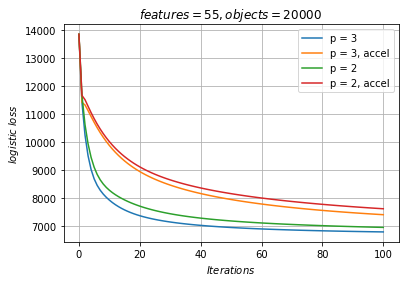

In [59]:
fig = plt.figure()

plt.xlabel(r'$Iterations$') 
plt.ylabel(r'$logistic \; loss$') 
plt.title(r'$features = {0}, objects = {1}$'.format(features_num, train_object_size)) 

arr_i = [i for i in range(NumIter + 1)]

plt.plot(arr_i, farr_tensor_3, label = 'p = 3')
plt.plot(arr_i, farr_tensor3_acc, label = 'p = 3, accel')
plt.plot(arr_i, farr_tensor2, label = 'p = 2')
plt.plot(arr_i, _acc_farr, label = 'p = 2, accel')

plt.legend()
plt.grid(True) 
fig.savefig('tensors_logistic_loss_iter.pdf')
plt.show()

##### Saving data

In [61]:
np.savetxt('farr_tensor_3_log_regr.txt', farr_tensor_3)
np.savetxt('farr_tensor3_acc_log_regr.txt', farr_tensor3_acc)
np.savetxt('farr_tensor2_log_regr.txt', farr_tensor2)
np.savetxt('farr_tensor2_acc_log_regr.txt', _acc_farr)